# Training

Im Rahmen dieses Notebooks werden drei Objekterkennungsmodelle zur Identifikation von Foreign Object Debris (FODs) also Fremdkörpern auf Flugbetriebsflächen trainiert. Die Evaluation und der Vergleich findet in dem evaluation.ipynb-Notebook statt.

In [1]:
import xml.etree.ElementTree as ET
import matplotlib.pyplot as plt
import numpy as np
import shutil
import cv2
import glob
import os

import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix
from ultralytics import YOLO

In [ ]:
# Definition of constants
BASE_URI = r"/data"
DATA_VOC_FOLDER = f"{BASE_URI}/FODPascalVOCFormat-V.2.1/VOC2007"
ANNOTATION_FOLDER = f"{DATA_VOC_FOLDER}/Annotations"
IMAGE_FOLDER = f"{DATA_VOC_FOLDER}/JPEGImages"

HEIGHT, WIDTH = 300, 300

In [2]:
print(tf.test.is_built_with_cuda())
print(tf.config.list_physical_devices("GPU"))

# Check for gpu
gpus = tf.config.experimental.list_physical_devices("GPU")

# Experimental memory growth lead to less out-of-memory errors
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

True
[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


## 1. Herunterladen des Datensatzes

Als Datensatz wird der Datensatz von Munyer et al. 2022 https://arxiv.org/pdf/2110.03072.pdf verwendet. Dieser enthält 26 Klassen von FODs aus unterschiedlichen Perspektiven und Lichtverhältnissen.

![](dataset.png)

In [2]:
!mkdir data
!wget --no-check-certificate "https://docs.google.com/uc?export=download&id=1zryvMCz51g1x9ynuRtJEh7iYF79bBVLz&confirm=no_antivirus" -O data/fod_dataset.zip

--2023-05-14 18:03:00--  https://docs.google.com/uc?export=download&id=1zryvMCz51g1x9ynuRtJEh7iYF79bBVLz&confirm=no_antivirus
Resolving docs.google.com (docs.google.com)... 74.125.199.138, 74.125.199.102, 74.125.199.101, ...
Connecting to docs.google.com (docs.google.com)|74.125.199.138|:443... connected.
HTTP request sent, awaiting response... 303 See Other
Location: https://doc-04-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vvskd7b1lr71vra7ake1aing44k7pcvl/1684087350000/13673145171457082740/*/1zryvMCz51g1x9ynuRtJEh7iYF79bBVLz?e=download&uuid=189964b3-afd0-48a1-91cb-808fe87ae136 [following]
--2023-05-14 18:03:00--  https://doc-04-2o-docs.googleusercontent.com/docs/securesc/ha0ro937gcuc7l7deffksulhg5h7mbp1/vvskd7b1lr71vra7ake1aing44k7pcvl/1684087350000/13673145171457082740/*/1zryvMCz51g1x9ynuRtJEh7iYF79bBVLz?e=download&uuid=189964b3-afd0-48a1-91cb-808fe87ae136
Resolving doc-04-2o-docs.googleusercontent.com (doc-04-2o-docs.googleusercontent.com)... 74.12

In [3]:
!unzip data/fod_dataset.zip -d data

Die letzten 5000 Zeilen der Streamingausgabe wurden abgeschnitten.
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028793.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028794.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028795.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028796.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028797.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028798.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028799.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028800.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028801.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028802.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028803.jpg  
  inflating: data/FODPascalVOCFormat-V.2.1/VOC2007/JPEGImages/028804.jpg  
  inflating: data/FODPascalVOCFor

## 2. Preprocessing des Datensatzes

Im Rahmen des Preprocessing werden die 26 Klassen auf 4 reduziert, um die Komplexität der Klassifikation zu verringern. Da der Datensatz im Pascal-VOC Format vorliegt, müssen zudem die Annotationen aus den XML-Files gelesen werden.

In [2]:
def load_annotation(image_id):
    tree = ET.parse(f"{ANNOTATION_FOLDER}/{image_id}.xml") 
    root = tree.getroot() # get root object

    bbox_coordinates = []
    for member in root.findall("object"):
        class_name = member.find("name").text
        bndbox = member.find("bndbox")
        
        # Bounding box coordinates
        xmin = float(bndbox.find("xmin").text)
        ymin = float(bndbox.find("ymin").text)
        xmax = float(bndbox.find("xmax").text)
        ymax = float(bndbox.find("ymax").text)
        
        # Store data in list
        bbox_coordinates.append((class_name, xmin, ymin, xmax, ymax))
    return bbox_coordinates


def label_image(mat, bbox_coordinates):
    for box in bbox_coordinates:
        label, x1, y1, x2, y2 = box

        x1 = int(x1)
        y1 = int(y1)
        x2 = int(x2)
        y2 = int(y2)

        cv2.rectangle(mat, (x1, y1), (x2, y2), (255,0,0), 2)
        cv2.putText(mat, label, (x1, y1-8), 0, 0.5, (255,0,0))

Um zu Prüfen, ob in den Trainingsdaten auch Observationen vorkommen, die mehrere Objekte enthalten, wurde die folgende Zelle verwendet. Tatsächlich sind Bilder vorhanden die mehrere Objekte enthalten. Eine Multi-Objekt-Detektion wird dennoch nicht trainiert.

In [ ]:
for id in range(30000):
    bbox = load_annotation(str(id).zfill(6))
    if len(bbox) > 1:
        print(id, bbox)
        break

8514 [('Label', 165.5547, 217.8611, 179.5414, 280.6528), ('Pliers', 135.3555, 270.7889, 175.7664, 300.0)]


In [ ]:
len(glob.glob(f"{ANNOTATION_FOLDER}/*.xml"))

33793

Insgesamt sind 33.793 Bilder zum Training und Testen im Datensatz vorhanden.

In [3]:
class_freq = {}

# Out of 31 classes will be 4 classes selected to reduce complexity
classes_of_interest = ["Wire", "Bolt", "Label", "LuggageTag"]
ids_of_interest = []

label_files = glob.glob(f"{ANNOTATION_FOLDER}/*.xml")
ids = [id.rpartition("\\")[-1][0:-4] for id in label_files]

for annot_id in ids:
    annots = load_annotation(annot_id)
    class_name = annots[0][0]

    if class_name not in class_freq:
        class_freq[class_name] = 0
    class_freq[class_name] += 1

    # Skip images with multiple objects
    if len(annots) > 1:
        continue

    if class_name in classes_of_interest:
        ids_of_interest += [annot_id]

print(class_freq)
print(len(ids_of_interest))

{'Battery': 1059, 'Bolt': 3300, 'BoltWasher': 1017, 'ClampPart': 917, 'MetalPart': 970, 'Cutter': 1352, 'PlasticPart': 2008, 'LuggageTag': 1686, 'Nail': 1193, 'Pliers': 2205, 'Label': 1310, 'Washer': 2139, 'Wrench': 2568, 'FuelCap': 548, 'Nut': 1303, 'MetalSheet': 394, 'Hose': 294, 'AdjustableClamp': 544, 'AdjustableWrench': 472, 'BoltNutSet': 514, 'Hammer': 760, 'LuggagePart': 738, 'PaintChip': 968, 'Pen': 483, 'Rock': 662, 'Screw': 157, 'Screwdriver': 811, 'Wire': 2138, 'SodaCan': 950, 'Tape': 127, 'Wood': 206}
7755


Von den 33.793 Bildern wird eine Teilmenge bestehend aus den vier Klassen $K_{Wire}$, $K_{Bolt}$, $K_{Label}$ und $K_{LuggageTag}$ zur Reduktion der Komplexität ausgewählt und Bildern, die nicht mehrere Objekte enthalten. Damit reduziert sich die Menge der Datenwerte auf 7.755 Elemente.

In [4]:
last_index = 0.0
class_encoding = {}

for coi in classes_of_interest:
    class_encoding[coi] = last_index
    last_index += 1
inv_class_encoding = {v: k for k, v in class_encoding.items()}

print(class_encoding)
print(inv_class_encoding)

{'Wire': 0.0, 'Bolt': 1.0, 'Label': 2.0, 'LuggageTag': 3.0}
{0.0: 'Wire', 1.0: 'Bolt', 2.0: 'Label', 3.0: 'LuggageTag'}


In [5]:
# This code could support multi-class object detection
# A value of one will consider just one object per image
MAX_LABELS = 1

def process_label(id):
    id = id.numpy().decode("utf-8")
    boxes = load_annotation(id)

    vec_class, vec_bbox = [], []

    for box in boxes:
        # Iterate over the box of every detected box
        class_name, xmin, ymin, xmax, ymax = box
        #width, height = (xmax-xmin) / 2, (ymax-ymin) / 2
        #center_x, center_y = width+xmin, height+ymin

        vec_class += [class_encoding[class_name]]
        vec_bbox += [xmin, ymin, xmax, ymax]

    # Fill rest of the vectors with zeros
    vec_class += [0] * (MAX_LABELS - len(vec_class))
    vec_bbox += [0] * (MAX_LABELS*4 - len(vec_bbox))

    return tf.constant(value=vec_class+vec_bbox, shape=MAX_LABELS*5, dtype=tf.float32)
        
def process_img(id):
    labels = tf.py_function(process_label, [id], Tout=[tf.TensorSpec(shape=MAX_LABELS*5, dtype=tf.float32)])
    class_label, bbox_label = tf.split(labels, num_or_size_splits=[MAX_LABELS, MAX_LABELS*4], axis=1)

    # Convert class_label to uint8 and then one-hot encode it using class_encoding
    class_label = tf.cast(class_label, tf.uint8)
    class_label = tf.one_hot(class_label, depth=len(class_encoding))
    class_label = tf.reshape(tf.squeeze(class_label), shape=[MAX_LABELS*len(class_encoding)])
    # Ensure the shape of bbox_label and normalize its values
    bbox_label = tf.ensure_shape(tf.squeeze(bbox_label), shape=(MAX_LABELS*4))
    bbox_label = bbox_label / 300.0

    # Read and decode the image from the constructed path
    img_path = tf.strings.join([IMAGE_FOLDER, "/", id, ".jpg"])
    img = tf.io.read_file(img_path)
    img = tf.image.decode_jpeg(img, channels=3)
    img = tf.image.convert_image_dtype(img, tf.float32)
    img = tf.image.resize(img, [WIDTH, HEIGHT])

    return img, (class_label, bbox_label)

def load_dataset(dataset_file):
    with open(dataset_file) as f:
        ids = [line.rstrip() for line in f]

    # Remove all ids not of interest
    ids = list(set(ids).intersection(ids_of_interest))

    # Use tensorflow dataset API to efficently deal with the data
    return tf.data.Dataset.from_tensor_slices(ids) \
            .map(process_img)

train_set = load_dataset(f"{DATA_VOC_FOLDER}/ImageSets/Main/trainval.txt")
test_set = load_dataset(f"{DATA_VOC_FOLDER}/ImageSets/Main/test.txt")

In [7]:
for t in train_set.take(1):
    print(t)

(<tf.Tensor: shape=(300, 300, 3), dtype=float32, numpy=
array([[[0.35686275, 0.3529412 , 0.33333334],
        [0.35686275, 0.3529412 , 0.33333334],
        [0.36078432, 0.35686275, 0.3372549 ],
        ...,
        [0.27450982, 0.27058825, 0.2509804 ],
        [0.27058825, 0.26666668, 0.24705884],
        [0.2627451 , 0.25882354, 0.2392157 ]],

       [[0.36078432, 0.35686275, 0.3372549 ],
        [0.36078432, 0.35686275, 0.3372549 ],
        [0.3647059 , 0.36078432, 0.34117648],
        ...,
        [0.27450982, 0.27058825, 0.2509804 ],
        [0.26666668, 0.2627451 , 0.24313727],
        [0.2627451 , 0.25882354, 0.2392157 ]],

       [[0.36078432, 0.35686275, 0.3372549 ],
        [0.3647059 , 0.36078432, 0.34117648],
        [0.3647059 , 0.36078432, 0.34117648],
        ...,
        [0.27058825, 0.26666668, 0.24705884],
        [0.26666668, 0.2627451 , 0.24313727],
        [0.2627451 , 0.25882354, 0.2392157 ]],

       ...,

       [[0.3921569 , 0.38823533, 0.37254903],
        [0.4

In [8]:
print(train_set.element_spec)
print("Lengths:", len(train_set), len(test_set))

(TensorSpec(shape=(300, 300, 3), dtype=tf.float32, name=None), (TensorSpec(shape=(4,), dtype=tf.float32, name=None), TensorSpec(shape=(4,), dtype=tf.float32, name=None)))
Lengths: 5825 1930


## 3. Training der Modelle
Die Prognose sieht zwei Zielvariablen vor, einerseits die Klasse $K$ des Objekts und die Lokalisierung $L$ über eine Bounding Box bestehend aus den Koordinaten $(x_1,y_1)$ und $(x_2,y_2)$. Das erste Tupel gibt hierbei den Eckpunkt in der oberen linken Ecke an und das zweite den dazu diagonal liegenden Eckpunkt in der unteren rechten Ecke.

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


[[0. 0. 0. 1.]] [[0.47705734 0.640088   0.7201536  0.7808703 ]]
LuggageTag [143.1172013282776, 192.02640652656555, 216.0460889339447, 234.26109552383423]
[[1. 0. 0. 0.]] [[0.36109367 0.38794434 0.5462187  0.65805566]]
Wire [108.3281010389328, 116.38330221176147, 163.86560797691345, 197.4166989326477]
[[0. 0. 0. 1.]] [[0.5140103  0.453963   0.575224   0.66584235]]
LuggageTag [154.2030930519104, 136.18890345096588, 172.5671947002411, 199.75270628929138]
[[0. 1. 0. 0.]] [[0.4732247  0.61710536 0.53091735 0.80789465]]
Bolt [141.96740984916687, 185.13160943984985, 159.27520394325256, 242.36839413642883]
[[0. 0. 1. 0.]] [[0.693802  0.5571297 1.        0.8230093]]
Label [208.14059972763062, 167.13890433311462, 300.0, 246.90279364585876]


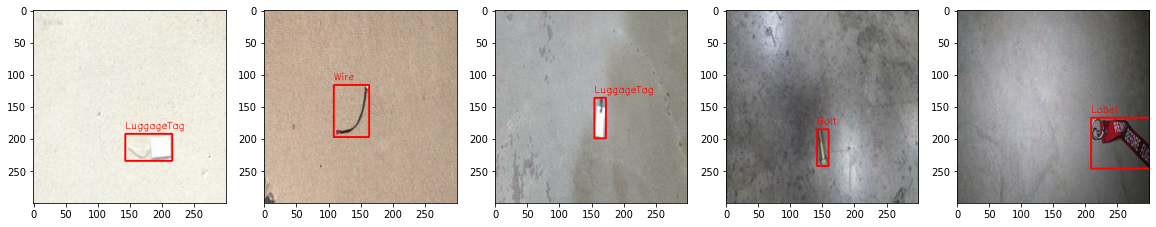

In [18]:
fig = plt.figure(figsize=(20, 7))
j = 1

for t in test_set.shuffle(16).take(5):
    img, label = t
    img = img.numpy()
    class_inds, bboxes = label

    class_inds = np.reshape(class_inds, [MAX_LABELS, len(class_encoding)])
    bboxes = np.reshape(bboxes, [MAX_LABELS, 4])

    print(class_inds, bboxes)

    for i in range(MAX_LABELS):
        class_label = inv_class_encoding[class_inds[i].argmax()]
        bbox = bboxes[i]
        bbox = [b * 300 for b in bbox]
        print(class_label, bbox)

        label_image(img, [[class_label, *tuple(bbox)]])

    fig.add_subplot(1, 5, j)
    plt.imshow(img)
    j += 1

Als Fehlerfunktion wird der Intersection-Over-Union Loss verwendet, der die Genauigkeit der vorhergesagten Bounding Boxen im Vergleich zu den tatsächlichen Bounding Boxen bewertet.

Die IoU-Metrik misst das Verhältnis zwischen dem Bereich der Schnittmenge (Intersection) und dem Bereich der Vereinigung (Union) zwischen der vorhergesagten Bounding Box und der tatsächlichen Bounding Box eines Objekts. Es wird durch die Formel IoU = Intersection / Union berechnet.

In [6]:
from tensorflow.python.keras import backend as K

def calculate_iou(target_boxes, pred_boxes):
    # Intersection of both bounding boxes
    x1 = K.maximum(target_boxes[..., 0], pred_boxes[..., 0])
    y1 = K.maximum(target_boxes[..., 1], pred_boxes[..., 1])
    x2 = K.minimum(target_boxes[..., 2], pred_boxes[..., 2])
    y2 = K.minimum(target_boxes[..., 3], pred_boxes[..., 3])

    inter_area = K.maximum(0.0, x2 - x1) * K.maximum(0.0, y2 - y1)
    
    # Areas of the individual bounding boxes
    target_area = (target_boxes[..., 2] - target_boxes[..., 0]) * (target_boxes[..., 3] - target_boxes[..., 1])
    pred_area = (pred_boxes[..., 2] - pred_boxes[..., 0]) * (pred_boxes[..., 3] - pred_boxes[..., 1])
    
    return inter_area / (target_area + pred_area - inter_area)

def loss_iou(y_truth, y_pred):
    # Use mean absolute error to avoid vanishing/exploding gradient
    mae = tf.losses.mean_absolute_error(y_truth, y_pred)
    iou = calculate_iou(y_truth, y_pred)
    return mae + (1 - iou)

In [7]:
def plot_history(history):
    fig = plt.figure(figsize=(16, 5))

    ax = fig.add_subplot(1, 2, 1)
    plt.plot(history.history["loss"])
    plt.plot(history.history["val_loss"])
    plt.title("Model loss while training")
    plt.ylabel("loss")
    plt.xlabel("epoch")
    plt.legend(["train", "val"])

    fig.add_subplot(1, 2, 2)
    plt.plot(history.history["classifier_accuracy"])
    plt.plot(history.history["val_classifier_accuracy"])
    plt.plot(history.history["locator_accuracy"])
    plt.plot(history.history["val_locator_accuracy"])
    plt.title("Model accuracy while training")
    plt.ylabel("accuracy")
    plt.xlabel("epoch")
    plt.legend(["train classifier", "val classifier", "train locator", "val locator"])
    plt.show()

In [8]:
# 90% for training - 10% for validation
train_size = int(len(train_set) * 0.9)

train_set_without_val = train_set.take(train_size).batch(8)
val_set = train_set.skip(train_size).batch(8)

print(train_size, len(train_set_without_val), len(val_set))

5242 656 73


### 3.1 Klassisches CNN ohne Transfer Learning

Das erste Modell ist ein klassisches CNN, das kein Transfer Learning nutzt. Es besitzt zwei Stränge zur Klassifikation bzw. Lokalisierung

In [9]:
input = layers.InputLayer(input_shape = (HEIGHT, WIDTH, 3))

# Dual branch for classification and bounding box regression
classifier = layers.Conv2D(32, (3, 3), activation="relu")(input.output)
classifier = layers.MaxPooling2D((2, 2))(classifier)
classifier = layers.Conv2D(64, (3, 3), activation="relu")(classifier)
classifier = layers.MaxPooling2D((2, 2))(classifier)
classifier = layers.Conv2D(128, (3, 3), activation="relu")(classifier)
classifier = layers.GlobalAveragePooling2D()(classifier)
classifier = layers.Dense(128, activation="relu")(classifier)
classifier = layers.Dense(MAX_LABELS*len(class_encoding), activation="softmax", name="classifier")(classifier) 

locator = layers.Conv2D(128, (3, 3), activation="relu")(input.output)
locator = layers.MaxPooling2D((2, 2))(locator)
locator = layers.Conv2D(256, (5, 5), activation="relu")(locator)
locator = layers.MaxPooling2D((2, 2))(locator)
locator = layers.Conv2D(512, (3, 3), activation="relu")(locator)
locator = layers.MaxPooling2D((2, 2))(locator)
locator = layers.Conv2D(512, (5, 5), activation="relu")(locator)
locator = layers.MaxPooling2D((2, 2))(locator)
locator = layers.Conv2D(256, (3, 3), activation="relu")(locator)
locator = layers.GlobalAveragePooling2D()(locator)
locator = layers.Dense(512, activation="relu")(locator)
locator = layers.Dense(MAX_LABELS*4, activation="sigmoid", name="locator")(locator)

# Build model
model = Model(input.input, outputs=[classifier, locator])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_3 (Conv2D)              (None, 298, 298, 12  3584        ['input_1[0][0]']                
                                8)                                                                
                                                                                                  
 max_pooling2d_2 (MaxPooling2D)  (None, 149, 149, 12  0          ['conv2d_3[0][0]']               
                                8)                                                            

In [10]:
losses = {
    "classifier": tf.keras.losses.CategoricalCrossentropy(), 
    "locator": loss_iou
}

loss_weights = {
    "classifier": 1.0, 
    "locator": 1.0
}

model.compile(loss=losses, loss_weights=loss_weights, optimizer="Adam", metrics=["accuracy"])

In [11]:
history = model.fit(train_set_without_val,
        validation_data=val_set,
        epochs=24
    )

Epoch 1/24
656/656 [==============================] - 292s 435ms/step - loss: 2.1110 - classifier_loss: 1.1418 - locator_loss: 0.9692 - classifier_accuracy: 0.4809 - locator_accuracy: 0.5639 - val_loss: 1.8559 - val_classifier_loss: 0.9338 - val_locator_loss: 0.9221 - val_classifier_accuracy: 0.5437 - val_locator_accuracy: 0.5935
Epoch 2/24
656/656 [==============================] - 290s 442ms/step - loss: 1.6327 - classifier_loss: 0.7328 - locator_loss: 0.8999 - classifier_accuracy: 0.6738 - locator_accuracy: 0.6391 - val_loss: 1.4963 - val_classifier_loss: 0.6539 - val_locator_loss: 0.8423 - val_classifier_accuracy: 0.6930 - val_locator_accuracy: 0.7221
Epoch 3/24
656/656 [==============================] - 290s 443ms/step - loss: 1.3831 - classifier_loss: 0.5769 - locator_loss: 0.8062 - classifier_accuracy: 0.7198 - locator_accuracy: 0.7413 - val_loss: 1.2794 - val_classifier_loss: 0.5434 - val_locator_loss: 0.7360 - val_classifier_accuracy: 0.7256 - val_locator_accuracy: 0.7890
Epoc

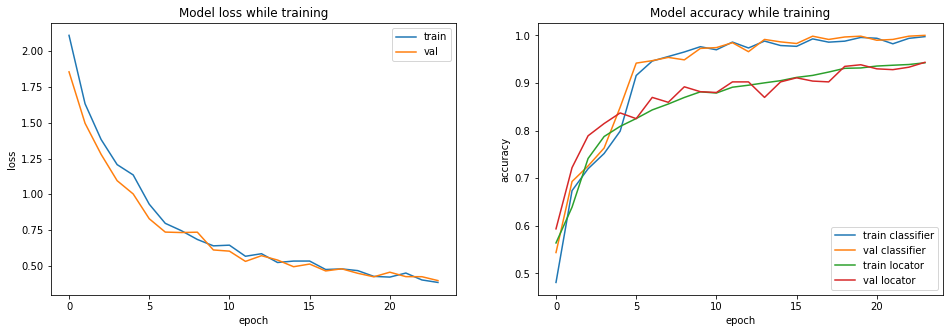

In [13]:
plot_history(history)

Das Training benötigte 114 Minuten.

In [12]:
model.save("models/cnn_self")

INFO:tensorflow:Assets written to: models/m31_self\assets


INFO:tensorflow:Assets written to: models/m31_self\assets


### 3.2 Transfer Learning: MobileNetV2 Backbone

Der zweite Ansatz verfolgt ein Transfer Learning, bei dem als Backbone das MobileNetV2 verwendet wird. 

In [21]:
backbone = tf.keras.applications.MobileNetV2(weights = "imagenet", include_top = False, input_shape = (HEIGHT, WIDTH, 3))

# Freeze layers of base model
backbone.trainable = False

# Dual branch for classification and bounding box regression
classifier = layers.GlobalAveragePooling2D()(backbone.output)
classifier = layers.Dropout(0.7)(classifier)
classifier = layers.Dense(256, activation="relu")(classifier)
classifier = layers.Dense(128, activation="relu")(classifier)
classifier = layers.Dense(MAX_LABELS*len(class_encoding), activation="softmax", name="classifier")(classifier) 

locator = layers.GlobalAveragePooling2D()(backbone.output)
locator = layers.Dropout(0.3)(locator)
locator = layers.Dense(512, activation="relu")(locator)
locator = layers.Dense(256, activation="relu")(locator)
locator = layers.Dense(64, activation="sigmoid")(locator)
locator = layers.Dense(MAX_LABELS*4, activation="sigmoid", name="locator")(locator)

# Build model
model = Model(backbone.input, outputs=[classifier, locator])
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 300, 300, 3  0           []                               
                                )]                                                                
                                                                                                  
 Conv1 (Conv2D)                 (None, 150, 150, 32  864         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 bn_Conv1 (BatchNormalization)  (None, 150, 150, 32  128         ['Conv1[0][0]']                  
                                )                                                             

In [24]:
losses = {
    "classifier": tf.keras.losses.CategoricalCrossentropy(), 
    "locator": loss_iou
}

loss_weights = {
    "classifier": 1.0, 
    "locator": 1.0
}

model.compile(loss=losses, loss_weights=loss_weights, optimizer="Adam", metrics=["accuracy"])

In [14]:
history = model.fit(train_set_without_val,
        validation_data=val_set,
        epochs=24
    )

Epoch 1/24
328/328 [==============================] - 67s 173ms/step - loss: 1.0333 - classifier_loss: 0.1515 - locator_loss: 0.8818 - classifier_accuracy: 0.9491 - locator_accuracy: 0.6522 - val_loss: 0.8168 - val_classifier_loss: 0.0018 - val_locator_loss: 0.8151 - val_classifier_accuracy: 1.0000 - val_locator_accuracy: 0.7307
Epoch 2/24
328/328 [==============================] - 53s 161ms/step - loss: 0.8487 - classifier_loss: 0.0534 - locator_loss: 0.7952 - classifier_accuracy: 0.9815 - locator_accuracy: 0.7385 - val_loss: 0.7389 - val_classifier_loss: 0.0015 - val_locator_loss: 0.7373 - val_classifier_accuracy: 1.0000 - val_locator_accuracy: 0.7804
Epoch 3/24
328/328 [==============================] - 53s 163ms/step - loss: 0.7696 - classifier_loss: 0.0301 - locator_loss: 0.7395 - classifier_accuracy: 0.9893 - locator_accuracy: 0.7963 - val_loss: 0.6689 - val_classifier_loss: 6.1982e-04 - val_locator_loss: 0.6682 - val_classifier_accuracy: 1.0000 - val_locator_accuracy: 0.8353
Epo

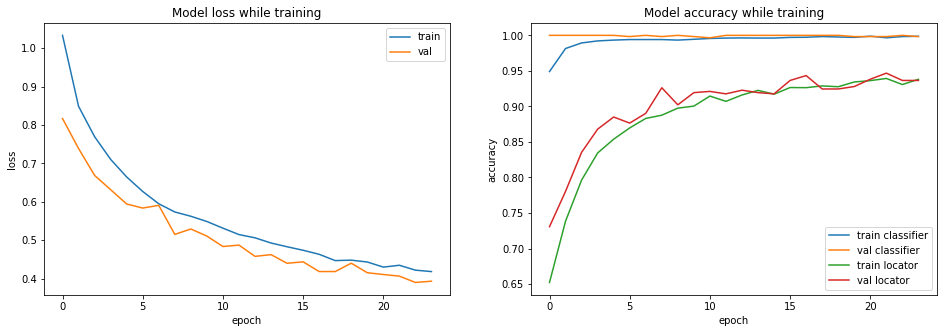

In [15]:
plot_history(history)

In diesem Fall dauerte das Training 30 Minuten.

In [16]:
model.save("models/mnv2_transfer")

INFO:tensorflow:Assets written to: models/m31\assets


INFO:tensorflow:Assets written to: models/m31\assets


In [25]:
model.load_weights("models/mnv2_transfer")

In [27]:
results = model.evaluate(test_set.batch(16))
print(results)

121/121 [==============================] - 12s 96ms/step - loss: 0.3972 - classifier_loss: 1.1216e-06 - locator_loss: 0.3972 - classifier_accuracy: 1.0000 - locator_accuracy: 0.9466
[0.3971901834011078, 1.1215936410735594e-06, 0.3971889317035675, 1.0, 0.9466321468353271]


### 3.3 Transfer Learning: YOLOv8 Modell

Der letzte Ansatz verfolgt die Nutzung von YOLOv8, als weitverbreitetes Modell zur Objekterkennung. Zum Training müssen der Trainingsdatensatz in ein anders Format überführt werden.

In [19]:
YOLO_V8_DATA = f"{BASE_URI}/YOLOv8TXTFormat/"

dirs = ["train", "val"]

# Function to transform bounding box coordinates
def transform_bbox(bbox):
    x1, y1, x2, y2 = bbox
    dw = 1./WIDTH
    dh = 1./HEIGHT

    # Calculate center and width/height
    w, h = x2 - x1, y2 - y1
    cx = x1 + w/2
    cy = y1 + h/2

    # Return normalized values
    return cx*dw, cy*dh, w*dw, h*dh

# Function to transform the dataset into YOLOv8 format
def transform_dataset(dataset_file, val_split=0.1):
    with open(dataset_file) as f:
        ids = [line.rstrip() for line in f]

    if not os.path.exists(YOLO_V8_DATA):
        os.makedirs(YOLO_V8_DATA)

    # Filtering ids to only those of interest
    ids = list(set(ids).intersection(ids_of_interest))

    train_size = int(len(train_set) * (1-val_split))
    train_ids, val_ids = ids[:train_size], ids[train_size:]

    # Processing train and validation subsets
    for sub_dir, ids in [(dirs[0], train_ids), (dirs[1], val_ids)]:
        sub_dir = f"{YOLO_V8_DATA}/{sub_dir}/"
        if not os.path.exists(f"{sub_dir}/images"):
            os.makedirs(f"{sub_dir}/images")
        if not os.path.exists(f"{sub_dir}/labels"):
            os.makedirs(f"{sub_dir}/labels")
        
        # Iterating through image ids
        for id in ids:
            annots = load_annotation(id)
            new_annots = ""

            # Transform and insert annotations
            for annot in annots:
                class_name, bbox = annot[0], annot[1:5]
                class_id = class_encoding[class_name]
                cx, cy, w, h = transform_bbox(bbox)
                new_annots += f"{int(class_id)} {cx} {cy} {w} {h}\n"

            with open(f"{sub_dir}/labels/{id}.txt", "w") as f:
                f.write(new_annots)
            
            # Copy image
            shutil.copy(f"{IMAGE_FOLDER}/{id}.jpg", f"{sub_dir}/images/{id}.jpg")

    # Create class file and data configuration
    with open(f"{YOLO_V8_DATA}/classes.txt", "w") as f:
        class_names = ""
        for class_name in class_encoding.keys():
            class_names += class_name + "\n"
        f.write(class_names)

    with open(f"{YOLO_V8_DATA}/data_custom.yaml", "w") as f:
        f.write(f"train: ./train\nval: ./val\n\nnc: {len(class_encoding)}\n\nnames: {list(class_encoding.keys())}")
    
transform_dataset(f"{DATA_VOC_FOLDER}/ImageSets/Main/trainval.txt")

C:\Users\dschm\Documents\DHBW\AI/YOLOv8TXTFormat//train/
C:\Users\dschm\Documents\DHBW\AI/YOLOv8TXTFormat//val/


In [2]:
model = YOLO("yolov8s.pt")

100%|██████████| 21.5M/21.5M [00:05<00:00, 4.30MB/s]


In [9]:
# Train the model
model.train(data=f"{YOLO_V8_DATA}/data_custom.yaml", epochs=64, imgsz=WIDTH)

New https://pypi.org/project/ultralytics/8.0.114 available  Update with 'pip install -U ultralytics'
Ultralytics YOLOv8.0.93  Python-3.10.4 torch-2.0.1+cu117 CUDA:0 (NVIDIA GeForce GTX 970, 4096MiB)
yolo\engine\trainer: task=detect, mode=train, model=yolov8s.pt, data=C:\Users\dschm\Documents\DHBW\AI/YOLOv8TXTFormat//data_custom.yaml, epochs=64, patience=50, batch=16, imgsz=300, save=True, save_period=-1, cache=False, device=None, workers=8, project=None, name=None, exist_ok=False, pretrained=False, optimizer=SGD, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=0, resume=False, amp=True, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, show=False, save_txt=False, save_conf=False, save_crop=False, show_labels=True, show_conf=True, vid_stride=1, line_width=None, visualize=False, augment=False, agnostic_nms

# Evaluation

1/1 [==============================] - 1s 1s/step


[[0. 1. 0. 0.]] [[0.7719433  0.19398443 0.8288552  0.35984984]]
Bolt [231.58298134803772, 58.1953302025795, 248.656564950943, 107.95495212078094]
1/1 [==============================] - 0s 35ms/step
[[1.2189426e-28 1.0000000e+00 0.0000000e+00 9.4942942e-29]] [[0.49371967 0.8663455  0.52687246 0.9974184 ]]
Bolt [148.11590015888214, 259.90365743637085, 158.0617368221283, 299.2255210876465]


1/1 [==============================] - 0s 30ms/step


[[1.0000000e+00 4.3656335e-21 5.8733423e-30 4.7793513e-29]] [[0.5119094  0.21125504 0.6958233  0.75364625]]
Wire [153.57282757759094, 63.37651312351227, 208.74699354171753, 226.09387636184692]
1/1 [==============================] - 0s 31ms/step
[[4.5362296e-38 0.0000000e+00 1.0000000e+00 0.0000000e+00]] [[0.3016967  0.3488032  0.6776106  0.67825115]]
Label [90.50900638103485, 104.64095771312714, 203.28317284584045, 203.4753441810608]


1/1 [==============================] - 0s 30ms/step
[[1.000000e+00 1.664026e-21 8.290376e-26 2.711210e-29]] [[0.03975219 0.4372325  0.36861116 0.99540174]]
Wire [11.925656720995903, 131.1697483062744, 110.58334708213806, 298.6205220222473]


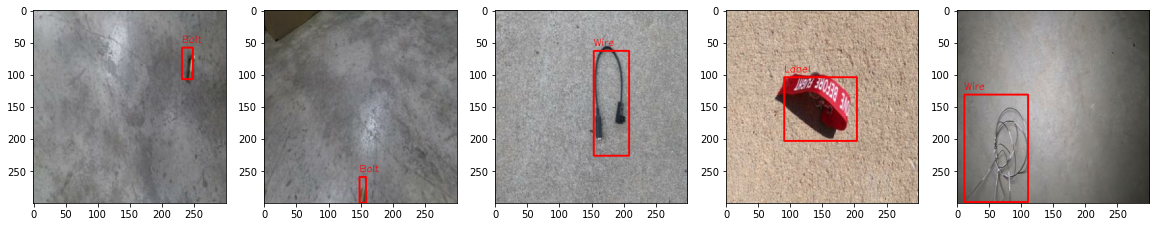

In [15]:
fig = plt.figure(figsize=(20, 7))
j = 1

for t in test_set.take(5):
    img, y_truth = t

    img = img.numpy()
    input_img = np.expand_dims(img, axis=0)
    class_inds, bboxes = model.predict(input_img)

    class_inds = np.reshape(class_inds, [MAX_LABELS, len(class_encoding)])
    bboxes = np.reshape(bboxes, [MAX_LABELS, 4])

    print(class_inds, bboxes)

    for i in range(MAX_LABELS):
        class_label = inv_class_encoding[class_inds[i].argmax()]
        bbox = bboxes[i]
        bbox = [b * 300 for b in bbox]
        print(class_label, bbox)

        label_image(img, [[class_label, *tuple(bbox)]])

    fig.add_subplot(1, 5, j)
    plt.imshow(img)
    j += 1

Innerhalb dieses Notebook wurden drei Modelle trainiert, deren Ergebnisse in der nachfolgenden Tabelle dargestellt sind:

| Modell | Anzahl der Parameter | Trainingsdauer | Genauigkeit Lokalisierung | Genauigkeit Klassifikation |
|---|---|---|---|---|
| CNN (ohne Transfer) | 9,98 mio | 116 min | 0,9434 | 1,0 |
| Transfer (MobileNetV2) | 3,42 | 42 min | 0,9365  | 0,9983 |
| Transfer (YOLOv8s) | 11,2 mio | 91 min | 0,998 | 1,0 |

Aus der Tabelle geht hervor, dass das Training eines CNN-Modells ohne Transfer Learning die längste Trainingsdauer besitzt. Dafür erreicht es eine Genauigkeit bei der Klassifikation von 1,0. Beide Transfer Learning Modelle weisen eine geringere Trainingsdauer auf, obwohl das YOLOv8s-Modell mit 11,2 Millionen Parameter circa 1,3 Millionen Parameter mehr besitzt.

Mit deutlichem Abstand besitzt das MobileNetV2-Transfer Learning Modell am wenigsten Parameter und benötigte mit 42 Minuten die geringste Zeit zum Training. Gleichzeitig fällt auch die Performance am schlechtesten aus.

Die besten Ergebnisse erzielt das YOLOv8s-Modell mit einer Genauigkeit bei der Lokalisierung von 0,998 und einer mittellangen Trainingsdauer von 91 Minuten.

# Konklusion
Während die Klassifikation mit über >99% Genauigkeit bei allen Modellen eine gute Performance erreicht, erreicht die Lokalisierung eine Genauigkeit von circa 93%. Es scheint, dass die Transfer-Learning-Modelle (MobileNetV2 und YOLOv8s) in diesem Szenario eine gute Balance zwischen Genauigkeit und Ressourcennutzung bieten. Wenn ein schnelles Training oder ein leichtgewichtiges Modell das Ziel ist, dann übersteigt das MobileNetV2 die anderen Modelle. Wenn die Genauigkeit im Fokus steht, kann das YOLOv8s-Modell die anderen Modelle schlagen.

Abschließend kann eine weitere Forschung die anderen Klassen oder die Erkennung mehrerer Objekte in einem Bild untersuchen. Zudem ist während eines praktischen Tests mit dem Vision System in dem vision.ipynb-Notebook aufgefallen, dass die Klassifikation auch in der Realität zuverlässig ist, jedoch die Lokalisierung sehr ungenau ist. Weiterführende Untersuchungen sollten daher zusätzliche Datensätze berücksichtgen, um mehr Varietät in den Datensatz zu bringen. 